In [2]:
import random
from collections import defaultdict, namedtuple
from itertools import product, starmap

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import Image, YouTubeVideo
from scipy import stats
%matplotlib inline
sns.set()
states_colors = matplotlib.colors.ListedColormap(
    ['#9A9A9A', '#D886BA', '#4D314A', '#6E9183'])
cmap_default = 'Blues'
cpal_default = sns.color_palette(("Blues_d"))

sns.set_style("white")
sns.set_context("poster")
random.seed(1)

# A Theory of Everything in 4x12 Squares
## Discovering Reinforcement Learning Without a Math Degree

Credit to [David Sanwald](https://davidsanwald.github.io/) for this tutorial


# Reinforcement Learning in 4x12 squares

Credit to [David Sanwald](https://davidsanwald.github.io/) for this tutorial

To take a closer look on RL, the model problem of a gridworld is borrowed from Sutton and Barto, two pioneers of RL.
Here is a plot of this gridworld:


![Cliffworld](cliff_map.png)


The world the agent has to deal with consists of just 4 $\times$ 12 squares, representing all of its possible **states**. The mechanics of this world are defined by a small number of rules:

1. The agent begins each episode on the green square in the upper left corner.
2. At each time step the agent can move one step.
3. The agent can't leave the board.
4. There are two ways an episode can end:
    1. The agent reaches the goal state
    2. The agent steps on one of the pink squares. If so, she falls off a cliff.
5. Living means suffering. Thus each time step the agent receives a negative reward of **-1**. If the agent falls off the cliff he gets a penalty of **-100**

So the basic loop of every agent environment interaction is:

```
while episode is non terminal: 
       agent chooses action
       environment changes state
       agent observes new state and receives reward for new state
       REPEAT
       
```

The goal of RL is to find the sequence of action which maximizes the expected return over time.

As simple as this model may be, it contains all building blocks needed, to describe a wide range of different problems apart from as grid shaped model environment.
Being a framework helping to formalize problems rather than a set of distinct methods it's sometimes more about posing problems to solve in the right manner, than a particular set of methods.

So what's the gridworld about?

Because life is cruel there's not much to win in this small gridworld. Every step the agent takes means pain thus the agent wants to end an episode as fast as possible. The only thing worse than taking step after step without finding a way to escape this suffering is to step on one of the cliff tiles, which means falling off a cliff and results in a painful punishment of *-100* and the termination of the current episode.
So in this model world, maximizing the reward (minimizing the negative reward) means finding the shortest path from the start state to the goal in the upper right corner without falling off the cliffs.

But of course the agent doesn't know any of this at all yet.


Next this small gridworld is created. Basically this domain has just two responsibilities:
    
    1. Receive the agent's action and change its state in response.
    2. Compute the reward signal for a state.
    
Other methods are only for logging states, making sure the agent doesn't make any impossible moves and checking whether an episode terminated or is still running.

The next cell contains the most important parameters of the cliffworld:

In [3]:
State = namedtuple('State', ['m', 'n'])

all_states = [State(0, 0), State(0, 1), State(0, 2), State(0, 3), State(0, 4),
              State(0, 5), State(0, 6), State(0, 7), State(0, 8), State(0, 9),
              State(0, 10), State(0, 11), State(1, 0), State(1, 1),
              State(1, 2), State(1, 3), State(1, 4), State(1, 5), State(1, 6),
              State(1, 7), State(1, 8), State(1, 9), State(1, 10),
              State(1, 11), State(2, 0), State(2, 1), State(2, 2), State(2, 3),
              State(2, 4), State(2, 5), State(2, 6), State(2, 7), State(2, 8),
              State(2, 9), State(2, 10), State(2, 11), State(3, 0),
              State(3, 1), State(3, 2), State(3, 3), State(3, 4), State(3, 5),
              State(3, 6), State(3, 7), State(3, 8), State(3, 9), State(3, 10),
              State(3, 11)]

cliff_states = all_states[1:11]
goal_state = State(m=0, n=11)
start_state = State(m=0, n=0)

terminal = cliff_states + [goal_state]
dflt_reward = -1
cliff_reward = -100

moves = {'>': State(0, 1),
         'v': State(1, 0),
         '<': State(0, -1),
         '^': State(-1, 0)}

parameters = {'all_states': all_states,
              'cliff_states': cliff_states,
              'goal_state': goal_state,
              'start_state': start_state,
              'terminal': terminal,
              'dflt_reward': dflt_reward,
              'cliff_reward': cliff_reward,
              'moves': moves}

Now it's possible to actually plot the map of the cliffworld.

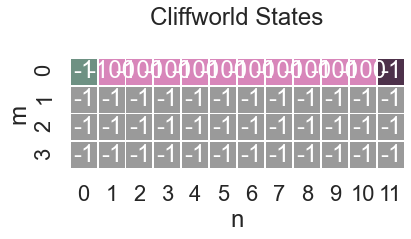

In [4]:
rewards = np.full((4,12), -1, dtype='int64')
color = np.zeros((4,12))
for x in all_states:
    if x == start_state:
        rewards[x] = -1
        color[x] = 4
    if x == goal_state:
        rewards[x] = -1
        color[x] = 2
    if x in cliff_states:
        rewards[x] = -100
        color[x] = 1

ax = sns.heatmap(color, cmap=states_colors, annot=rewards, cbar=False, square=True, linewidths=1, fmt='' )
ax.set_title('Cliffworld States\n')
ax.set(ylabel='m', xlabel='n')
plt.show()

In [5]:
class CliffWorld:
    """Cliffworld domain for RL.

    A simple domain with 4 x 12 = 48 possible discrete states.
    Originally from Sutton and Barto:
    http://webdocs.cs.ualberta.ca/~sutton/book/ebook/node65.html

    Args:

    Specified in the dictionary above because this class is not
    intended for use outside this notebook.


    """

    def __init__(self, *initial_data, **kwargs):
        for dictionary in initial_data:
            for key in dictionary:
                setattr(self, key, dictionary[key])
        for key in kwargs:
            setattr(self, key, kwargs[key])
        self.record_list = []
        self.position = [self.start_state]
        self.log_dict = {}
        self.reward_sum = 0

    def newstate(self, state, action):
        """Computes the newstate.

        Takes a state and an action from the agent and computes its next position.

        Args:
            state: a tuple (m, n)  representing the coordinates of the current state
            action: index of an action

        Returns:
            newstate: a tuple (m, n) representing the coordinates of the new position

        """
        move = moves[action]
        newstate = State(state.m + move.m, state.n + move.n)
        self.position.append(newstate)
        return newstate

    def reward(self, state):
        """Computes the reward signal for a given state.

        Takes a state and checks if it's a cliff or just a normal state.

        Args:
            state: a named tuple (m, n) 
                representing the coordinates of the current state.

        Returns:
            reward: a scalar value. -100 for a cliff state, -1 otherwise.

        """
        if state in self.cliff_states:
            reward = self.cliff_reward
        else:
            reward = self.dflt_reward
        self.reward_sum += reward
        return reward

    def is_terminal(self, state):
        """Checks if state is terminal.

        If the agent reached its goal or fell off a cliff the episode ends.
        Otherwise it will continue.

        Args:
            state: namedtuple, State(m, n), representing position.

        Returns:
            True if state is terminal, False otherwise.

        """
        if state in self.terminal:
            self.log_stuff(state)
            return True
        else:
            return False

    def log_stuff(self, state):
        """Log things for analysis.

        You can safely ignore this.
        I will refactor this as a mixin or use a decorator instead later.

        """
        self.position.append(state)
        self.log_dict['visited_states'] = self.position[:]
        self.log_dict['reward'] = self.reward_sum
        self.record_list.append(self.log_dict)
        self.log_dict = {}
        self.position = [self.start_state]
        self.log_dict = {}
        self.reward_sum = 0
        pass

    def valid_actions(self, state):
        """Compute valid actions for given state.

        It's unimportant for understanding RL. Just ignore.

        """

        valid_actions = []
        if (state.m + moves['>'].m, state.n + moves['>'].n) in self.all_states:
            valid_actions.append('>')
        if (state.m + moves['v'].m, state.n + moves['v'].n) in self.all_states:
            valid_actions.append('v')
        if (state.m + moves['<'].m, state.n + moves['<'].n) in self.all_states:
            valid_actions.append('<')
        if (state.m + moves['^'].m, state.n + moves['^'].n) in self.all_states:
            valid_actions.append('^')
        return valid_actions

A good way to understand how environment and agent interact is to write a simple agent which just chooses actions at random.
Even though the agent does not learn anything at all, the interface to the environment will be the same for the Q-learning agent following next.

The agent needs only 2 methods. One chooses and executes an action in the environment, the other one learns from the reward following this action and the resulting new state.
Of course the learning method of the random agent doesn't do anything at all.

In [6]:
class RandomAgent:
    """Just choosing actions at random. Learns nothing.

    We write this for the purpose of understanding the interface between
    agent and domain we later use for the real RL-agent.

    """

    def __init__(self):
        self.reward_sum = 0
        pass

    def act(self, state, valid_actions):
        """Take state and valid actions for that state. Return  action."""
        action = random.choice(valid_actions)
        return action

    def learn(self, state, action, newstate, reward):
        """Never learns anything. Basically like the AFD."""
        self.reward_sum += reward
        pass

Now this random agent and the Cliffworld domain class are instantiated. Their loop of interaction is exactly the same as the loop described above.

In [19]:
#: Just some agent randomly roaming through a 
#: gridlike domain with 4x12 discrete states.
#: Occasionally jumping off cliffs.
#: Hey, it's still a better lovestory than Twilight.

random_agent = RandomAgent()    #: Instantiate an agent object
domain = CliffWorld(parameters) #: Create our small world

def run_episode(domain, agent):
    state = domain.start_state
    while not domain.is_terminal(state):
        valid_actions = domain.valid_actions(state) #: Get a list of allowed moves for the current state.
        action = agent.act(state, valid_actions)    #: Take the current state as input and compute an action.
        newstate = domain.newstate(state, action)   #: Take the action and compute the changed state.
        reward = domain.reward(newstate)            #: Compute reward.
        agent.learn(state, action, newstate, reward)#: Learn.
        state = newstate                            #: Newstate becomes the current state for next iteration.
    pass

run_episode(domain, random_agent)



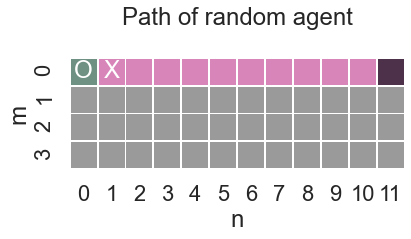

In [22]:
agent_position_log = domain.record_list[-1]['visited_states']

agent_path = np.empty((4, 12), dtype=str)

for state_visited in agent_position_log:
    if state_visited in terminal:
        agent_path[state_visited] = 'X'
    else:
        agent_path[state_visited] = 'O'

ax = plt.axes()
ax.set_title('Path of random agent\n')
figure = sns.heatmap(color,
                     annot = agent_path,
                     fmt = '',
                     ax=ax,
                     cbar=False,
                     linewidth = 1,
                     cmap = states_colors,
                     square=True)
figure.set(xlabel='n', ylabel='m')
plt.show()

Clearly just acting randomly doesn't get the agent very far or even worse, sooner or later he dies by falling off a cliff when he steps on one of the pink tiles representing terminal states.
So there has to be another way.

Not only reinforcement learning but learning in general utilizes just two main principles (or combinations of it).

#### Model based methods

Learning a model means using experience to estimate the actual mechanics of an environment. This means being able to plan, to know the possible consequences of a decision before it's executed.

An important advantage of this approach is that its use of the available data/experience is very efficient. The biggest downside is that planning in general is  computationally quite expensive. 
Model based approaches could be favourable for applications like robotics where it's difficult to collect large amounts of data but the slowness of the robot's actions leaves enough time for the necessary computations to use the model to plan a sequence of actions and its consequences.

#### Value based methods

The approach explored in the following is fundamentally different from using a model. Value based learning means to use experience to estimate a function which assignes a value to every possible state action pair telling the learner how good this pairing is in terms of maximizing the long term return of rewards. Even though later models of biological learning (like the work by [Rescola and Wagner](http://www.scholarpedia.org/article/Rescorla-Wagner_model)) are even closer to value based algorithms used today even classical conditioning, first discovered by Ivan Pavlov in his famous [dog experiment](https://en.wikipedia.org/wiki/Ivan_Pavlov) where a dog begins to relate some conditioned stimulus (the ringing of a bell) to a following unconditioned stimulus (food) is surprisingly similar to the Q-learning algorithm implemented in the following.

## The concept of a value function

The goal is to find a sequence of actions which maximizes the expected return of rewards in the gridworld. 
So maybe it is enough to learn from experience how "good" it is to take some action in a particular state.
If it's possible to learn a function which expresses this by assigning a value to every state action pair it's possible to just take the highest valued action in every state and finally find the goal.

But how?

For every action the agent receives a reward. Sometimes there's a discount on this reward, so that that reward on the next step is favorable to a reward in the distant future.
At time step $t$ the return $G_t$ is the sum of all future rewards from that time step on

$$G_{t} = r_{t+1}+r_{t+2}+r_{t+3}+\dots +r_{n}$$

In the discounted case, rewards get multiplied with some $\gamma<0$ raised to the power of the number of time steps this reward is away from the next reward. So if a reward is $k$ time steps aways it's discounted by $\gamma^{k-1}$:

$$ G_{t} = r_{t+1}+ \gamma r_{t+2}+ \gamma^2 r_{t+3}+ \dots  = \sum_{k=0}^{\infty}\gamma^k r_{t+k+1} $$

Because the future is unknown, the return has to be expressed in a different way. It is possible to understand the return as the sum of just two parts:

$$G_{t}= r_{t+1} + \gamma G_{t+1}$$

The return at time stept $t$ is the immediate reward on the next time step $r_{t+1}$ plus the discounted return from this time step on.

This can be used to introduce a function, $Q(s,a)$ , which assigns some value to every possible action in each state which tells the agent how good this action is in terms of maximizing the return $G_{t}$.

The Q function can be split in the same manner as the return $G_{t}$. The maximum value for taking some action $a$ in state $t$ is the sum of the reward for taking that action and the maximum (discounted) value for taking the optimal action on the next time step. 

$$Q(s_t,a_t)= r_{t+1} + \gamma max_{a_{t+1}} Q(s_{t+1}, a_{t+1})$$

The agent has to learn $Q(s, a)$ which maps all state action pairs to a value which has to be as close as possible to the *true* value of a state action pair. If a good estimate of the true Q-values is known, the agent just has to take the highest valued action in every state.
This leads to the learning rule of the Q-learning algorithm (the use of capital letters indicates actual tabular values):

$$Q(S_{t}A_{t})\gets Q(S_{t}A_{t})+\alpha[R_{t+1}+\gamma \max_{A}Q(S_{t+1},A)-Q(S_{t},A_{t})]$$

The agent has some estimate of the value of taking action $A_t$ in state $S_t$. Now he executes this action and receives the reward $R_{t+1}$ in return. And because of the definition above  $Q(s_t,a_t)$ can be updated with the new information. The direction of the update is determined by the immediate reward the agent receives plus the (discounted) difference between the maximum of the estimate $Q(S_{t+1})$ of the state we now reached times some small step size parameter $\alpha$.

A simple intuition for this:

Because the value of a state action pair $Q(S_t,A_t)$ can be estimated as the reward $R_{t+1}$ for taking that action plus the estimated value $Q(S_{t+1},A_{t+1})$ for taking the best action on the next time step, we can update our estimate of $Q(S_t,A_t)$ when we receive the actual reward $R_{t+1}$ on the next time step.

If you think you'll need 60 minutes for the way from your home to your workplace but you get in a traffic jam after 10 minutes you already know you'll be late and can call your boss before actually arriving. 
The closer you get to your workplace, the smaller your updates to your estimated arrival will get.
If you're at the first floor but notice the elevator isn't working that day, having to take the stairs does not change the time you estimated for the way from home to work anymore.

This part is also called $[R_{t+1}+\gamma \max_{a}Q(S_{t+1},a)-Q(S_{t},A_{t})]$ or the temporal difference error.
Actually this TD-error could also be called *surprise*. It's an expressions of the difference between an actual experience and the expectation preceding this experience. The intuition that the amount of surprise and learning are closely related is indeed congruent to some results of neuroscientific [research](http://link.springer.com/article/10.3758/BF03196058).

Updating expectations by the difference to actual experience results in the following algorithm:

```
initialize values Q[states, actions] arbitrarily (as zero)
begin at start state S
    while episode non terminal:
        execute action A with highest Q
        observe reward R' and newstate S'
        Q[S, A] = Q[S', A']+ alpha * [R'+ gamma max_a[Q[S', A'] - Q[S, A]]
        S = S'
        
```

Because the agent doesn't know anything yet, all Q-values are initialized as zero. For the cliffworld this could be an array with the size $possible\, states \times actions$. For the gridworld the array would consist of $(4 \times 12) \times 4$ tiles because the agent can go *left*, *right*, *up* or *down*.
Often the number of possible states isn't known beforehand, so Python's *defaultdict* keyed by a nested tuple in the form (action (row-index, colum-index)) could be used instead of an array. Whenever there's no existing value for a state/action-key the dictionary returns 0.

There's one more thing to know and that's $\epsilon-greedy$ action selection.
If someone exploits just the knowledge he already possesses and never tries anything new, he also won't be able to discover or *learn* anything new.
So the agent selects her actions $\epsilon-greedy$: In a proportion of $1-\epsilon$ times he doesn't select the action with the highest value and just chooses one at random instead. The value of $\epsilon$  is decreased over time as the experience grows.

I think it often wouldn't be a bad idea if we all **increased** our personal $\epsilon$ and just dared to try something new from time to time (:


The python manifestation of the Q-learning agent:

In [23]:
class QAgent:
    """Q-Learning agent.

    A value based, off-policy RL-agent.
    Uses defaultdict to return 0 for unknown state/action pairs.
    This has the same purpose as initializing all unknown states to zero.


    Args:
        epsilon: Parameter for epsilon-greedy action selection.
        epsilon_modifier: scalar value between 0 and 1,
        decay factor for epsilon
        alpha: Learning rate or stepsize. Usually <<1
        gamma: discount of future rewards <=1

    Attrs:
        Q: Python defaultdict with defaultvalue 0 containing
        the Q-values for state action pairs.
        Keyed by a nested state action tuple.
        Example:
        {
            (State(m=0, n=0), '>'): -99.94360791266038,
            (State(m=0, n=0), 'v'): -1.1111111111107184,
            (State(m=1, n=0), '>'): -1.111111111107987,
            (State(m=1, n=0), 'v'): -1.1111111111079839,
            (State(m=1, n=0), '^'): -1.111111111108079
        }
        A: Defaultdict keyed by state tuple, values
        are keys of executed actions. Is used to determine
        whether an action in a state took place in the past.
        If there's no memory len(A[state]) == 0


    """

    def __init__(self, alpha, epsilon, gamma):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.Q = defaultdict(int)
        self.A = defaultdict(set)
        self.td_list = []

    def act(self, state, valid_actions):
        """Choose action.

        Take state tuple and valid actions and choose action.
        Action can either be random or greedy to ensure exploration.
        Probability of selecting random actions depends on epsilon.
        Smaller epsilon means less randomness.

        Args:
            state: state tuple (n,m) describes current position.
            valid_actions: list of indices of valid actions for a state.

        Returns:
            action: Index of selected action.
            Can either be chosen at random or greedily.

        """
        if random.random() > self.epsilon:
            action = self.act_greedy(state, valid_actions)
        else:
            action = self.act_random(valid_actions)
        return action

    def learn(self, state, action, newstate, reward):
        """Compute update of Q-function.

        Update Q-values when reaching new state and receiving reward.
        New value equals to the old value + the computed td-error times
        the stepsize parameter alpha.
        Also adds the executed action to A, to keep track of all state
        action pairs.


        Args:
            state: namedtuple (m, n) the state of the last timestep.
            action: index of executed action at the last timestep.
            newstate: current state reached after executing action.
            reward: scalar value received for reaching newstate.


        Returns:
            pass

        """
        self.Q[state, action] = (self.Q[state, action] + self.alpha *
                                 (self.td(state, action, newstate, reward)))
        self.A[state].add(action)
        pass

    def act_random(self, valid_actions):
        """Choose index of action from valid actions at random.

        Called either if epsilon greedy policy returns random
        or if there's no previous knowledge of action values for
        a state.

        Args:
            valid: List of indices of valid actions for a state.

        Returns:
            action: Index of selected action.
                Can either be chosen at random or greedy.

        """
        random_action = random.choice(valid_actions)
        return random_action

    def act_greedy(self, state, valid_actions):
        """Choose action with the highest Q-value.

        First checks whether the agent previously has executed any actions at all
        in the current state. If not it calls the random act_random method.

        Args:
            valid_actions: List of indices of valid actions for a state.
            state: namedtuple, State(n, m),
                representing coordinates of the current state.

        Returns:
            chosen_action: Index of selected action.
                Can either be chosen at random or greedy.

        """
        if len(self.A[state]) == 0:
            chosen_action = self.act_random(valid_actions)
        else:
            q_s = {actions: self.Q[state, actions]
                   for actions in self.A[state]}
            chosen_action = max(q_s, key=q_s.get)
        return chosen_action

    def td(self, state, action, newstate, reward):
        """Compute td error to update value dict

        First checks wether the agent previously as executed any actions at all in
        the current state. If not the maximum Q-value for that state defaults to 0.
        It fetches Q-values for all previously exectued actions in newstate tracked in A.
        Next computes the key of the largest Q-value and queris the fetches Q-values.
        Finally computes the td error for the learning update.

        Args:
            state: state of the last timestep.
            action: index of selected action in that state
            newstate: state the agent just reached.
            reward: scalar value

        Returns:
            td: td error. You know, cocaine, baby.

        """
        if len(self.A[newstate]) == 0:
            max_qval = 0
        else:
            q_vals = {actions: self.Q[newstate, actions]
                      for actions in self.A[newstate]}
            max_qval_key = max(q_vals, key=q_vals.get)
            max_qval = q_vals[max_qval_key]
        td = reward + self.gamma * max_qval - self.Q[state, action]
        self.td_list.append(td)
        return td

The only thing missing to finally test our Q-Agent is a function to conduct multiple episodes.
As the agent progresses, the amount of exploration by acting randomly is gradually reduced on each episode by modifying epsilon with a decay parameter. For evaluation purposes in the last episode the the agent exploits the learned value function without any exploration.

In [24]:
def run_experiment(domain, agent, epsilon_decay, n_episodes):
    for i in range(n_episodes):
        agent.epsilon *= epsilon_decay
        run_episode(domain, agent)
    print('Setting epsilon paramter to zero',
          'to prevent random actions and evaluate learned policy.\n')
    agent.epsilon = 0
    run_episode(domain, agent)
    last_reward = domain.record_list[-1]['reward']
    print('Trained for {0} episodes.\n' 
          '\nGained reward of {1} points in the last episode.'.format(n_episodes, last_reward))                       
    pass


In [25]:
epsilon = 0.9
epsilon_decay = 0.99
gamma = 0.9
alpha = 0.25
n_episodes = 500

In [26]:
q_agent = QAgent(alpha, epsilon, gamma)
domain = CliffWorld(parameters)

In [27]:
run_experiment(domain, q_agent, epsilon_decay, n_episodes)

logged_data = domain.record_list
Q_table = q_agent.Q
A_table = q_agent.A
td = q_agent.td_list

Setting epsilon paramter to zero to prevent random actions and evaluate learned policy.

Trained for 500 episodes.

Gained reward of -13 points in the last episode.


In [28]:
action_array = np.empty((4,12), dtype=str)
value_array = np.empty((4,12), dtype=float)
for state in domain.all_states:
    if len(A_table[state])==0:
        chosen_action = 'c'
    else:
        q_s = {actions: Q_table[state, actions] 
               for actions in A_table[state]}
        chosen_action = max(q_s, key=q_s.get)
        max_qval = q_s[chosen_action]
    action_array[state] = chosen_action
    value_array[state] = max_qval
    action_array[(0,11)] = 'g'
    

    

    

The following code visualizes what the agent has learned:

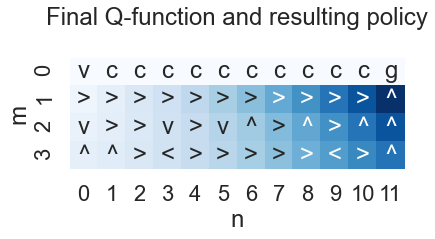

In [29]:
figure = sns.heatmap(value_array, annot = action_array,  fmt= '', square=True, cbar=False, cmap= cmap_default)
ax = plt.axes()
ax.set_title('Final Q-function and resulting policy\n')
figure.set(xlabel='n', ylabel='m')
plt.show()

Here is the final path of the agent. By tweaking some of the parameters it's easy to find a combination which converges to the shortest path (:

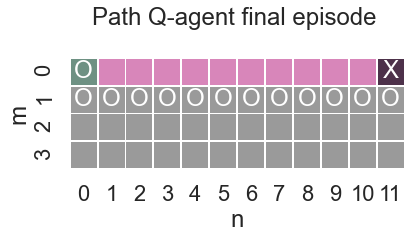

In [30]:
agent_position_log = domain.record_list[-1]['visited_states']

agent_path = np.empty((4, 12), dtype=str)

for state_visited in agent_position_log:
    if state_visited in terminal:
        agent_path[state_visited] = 'X'
    else:
        agent_path[state_visited] = 'O'

ax = plt.axes()
ax.set_title('Path Q-agent final episode \n')
figure = sns.heatmap(color,
                     annot=agent_path,
                     fmt='',
                     ax=ax,
                     cbar=False,
                     linewidth=1,
                     cmap=states_colors,
                     square=True)
figure.set(xlabel='n', ylabel='m')
plt.show()

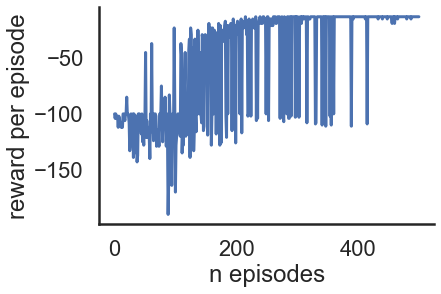

In [31]:
points = [i['reward'] for i in logged_data]
figure = sns.lineplot(x=np.arange(len(points)), y=points)
figure.set(xlabel='n episodes', ylabel='reward per episode')
sns.despine()

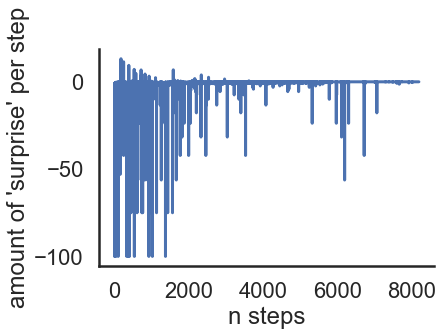

In [32]:
figure = sns.lineplot(x=np.arange(len(td)), y=td)
figure.set(xlabel='n steps', ylabel="amount of 'surprise' per step")
sns.despine()